In [1]:
import tensorflow as tf
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split

2025-11-11 19:28:11.176078: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-11-11 19:28:11.176489: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-11 19:28:11.224105: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-11-11 19:28:12.185320: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To tur

In [2]:
ven_info = pd.read_csv("image_data/venomous_status_metadata.csv", names=["nid", "class_id", "ven"], header=0)
train_info = pd.read_csv("image_data/train_images_metadata.csv", index_col=0)
relevant = train_info[["image_path", "class_id",]].merge(ven_info, on="class_id")
n_classes = len(ven_info)

In [3]:
def load_and_preprocess(img_path, y1, y2=None, img_size=(240, 240), one_hot=True, name1="class_id"):
    img = tf.io.read_file("image_data/train_images_small/" + img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, img_size)
    img = tf.cast(img, tf.float32) / 255.0
    if one_hot: y1 = tf.one_hot(y1, depth=n_classes)
    if y2 is None: return img, {name1: y1}
    return img, {name1: y1, "ven": y2}

def make_dataset(df, shuffle=True, cid=True, ven=True):
    lp = load_and_preprocess
    
    if cid and ven: slices = (df['image_path'].values, df['class_id'].values, df['ven'].values)
    elif cid: slices = (df['image_path'].values, df['class_id'].values)
    else:
        slices = (df['image_path'].values, df['ven'].values)
        lp = lambda ip, v: load_and_preprocess(ip, v, one_hot=False, name1="ven")
    ds = tf.data.Dataset.from_tensor_slices(slices)
    ds = ds.map(load_and_preprocess, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        ds = ds.shuffle(buffer_size=len(df))
    ds = ds.batch(32).prefetch(tf.data.AUTOTUNE)
    return ds

In [4]:
train_paths, val_paths = train_test_split(relevant, test_size=0.2, random_state=42)
train_ds = make_dataset(train_paths, shuffle=False) #false shuffle here is just temporary for testing
val_ds = make_dataset(val_paths, shuffle=False)

2025-11-11 19:28:18.863390: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [5]:
from tensorflow.keras.layers import Flatten, Conv2D, Dense, Input, MaxPooling2D, Dropout
from tensorflow.keras import losses
from tensorflow.keras import Model

In [6]:
inp = Input(shape=(240, 240, 3))
x = Conv2D(16, (5, 5), padding="valid")(inp)
x = MaxPooling2D(pool_size=(5,5))(x)
x = Conv2D(64, (3, 3), padding="valid")(x)
x = MaxPooling2D(pool_size=(3,3))(x)
x = Conv2D(32, (3, 3), padding="valid")(x)
x = MaxPooling2D()(x)
x = Flatten()(x)
x = Dense(32, activation="relu")(x)
x = Dense(32, activation="relu")(x)
class_output = Dense(n_classes, activation="softmax", name='class_id')(x)
ven_output = Dense(1, activation="sigmoid", name='ven')(x)

model = Model(inputs=inp, outputs=[class_output, ven_output], name='model')
model.summary()

Model: "model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 240, 240,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 236, 236,  │      1,216 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 47, 47,    │          0 │ conv2d[0][0]      │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 45, 45,    │      9,280 │ max_pooling2d[0]… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 15, 15,    │          0 │ conv2d_1[0][0]    │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 13, 13,    │     18,464 │ max_pooling2d_1[… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 6, 6, 32)  │          0 │ conv2d_2[0][0]    │
│ (MaxPooling2D)      │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1152)      │          0 │ max_pooling2d_2[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 32)        │     36,896 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 32)        │      1,056 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ class_id (Dense)    │ (None, 296)       │      9,768 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ ven (Dense)         │ (None, 1)         │         33 │ dense_1[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 76,713 (299.66 KB)

 Trainable params: 76,713 (299.66 KB)

 Non-trainable params: 0 (0.00 B)

In [7]:
model.compile(
    optimizer= tf.keras.optimizers.Adam(),
    loss={'class_id': losses.CategoricalCrossentropy(), 'ven': losses.BinaryCrossentropy},
    metrics={'class_id': 'accuracy', 'ven': 'accuracy'})

In [8]:
%%time
history = model.fit(train_ds, validation_data=val_ds, epochs=3)

Epoch 1/3
1375/1662 ━━━━━━━━━━━━━━━━━━━━ 23s 83ms/step - class_id_accuracy: 0.7448 - class_id_loss: 3006388697.9857 - loss: 3603074997.9504 - ven_accuracy: 0.7046 - ven_loss: 596685051.9801

2025-11-11 19:30:21.969523: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1662/1662 ━━━━━━━━━━━━━━━━━━━━ 157s 94ms/step - class_id_accuracy: 0.8651 - class_id_loss: 55651799040.0000 - loss: 65432621056.0000 - ven_accuracy: 0.6865 - ven_loss: 9818946560.0000 - val_class_id_accuracy: 0.8967 - val_class_id_loss: 360904622080.0000 - val_loss: 534344728576.0000 - val_ven_accuracy: 0.7932 - val_ven_loss: 173053755392.0000
Epoch 2/3
1374/1662 ━━━━━━━━━━━━━━━━━━━━ 26s 92ms/step - class_id_accuracy: 0.8931 - class_id_loss: 1038986183681.4905 - loss: 1229372298056.6638 - ven_accuracy: 0.6920 - ven_loss: 190386255761.7001

2025-11-11 19:33:10.623726: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1662/1662 ━━━━━━━━━━━━━━━━━━━━ 175s 105ms/step - class_id_accuracy: 0.8942 - class_id_loss: 2983494156288.0000 - loss: 3457532559360.0000 - ven_accuracy: 0.6850 - ven_loss: 473565724672.0000 - val_class_id_accuracy: 0.8967 - val_class_id_loss: 7801362972672.0000 - val_loss: 9667079045120.0000 - val_ven_accuracy: 0.7932 - val_ven_loss: 1855364923392.0000
Epoch 3/3
1375/1662 ━━━━━━━━━━━━━━━━━━━━ 25s 90ms/step - class_id_accuracy: 0.8931 - class_id_loss: 12310157419038.1621 - loss: 14224770102603.4043 - ven_accuracy: 0.6892 - ven_loss: 1914618301358.8247

2025-11-11 19:36:02.834071: W tensorflow/core/lib/png/png_io.cc:95] PNG warning: iCCP: extra compressed data


1662/1662 ━━━━━━━━━━━━━━━━━━━━ 167s 100ms/step - class_id_accuracy: 0.8942 - class_id_loss: 20423876018176.0000 - loss: 23375894282240.0000 - ven_accuracy: 0.6865 - ven_loss: 2945463353344.0000 - val_class_id_accuracy: 0.8967 - val_class_id_loss: 34158017511424.0000 - val_loss: 38391563419648.0000 - val_ven_accuracy: 0.7932 - val_ven_loss: 4184045256704.0000
CPU times: user 52min 34s, sys: 27.6 s, total: 53min 2s
Wall time: 8min 19s


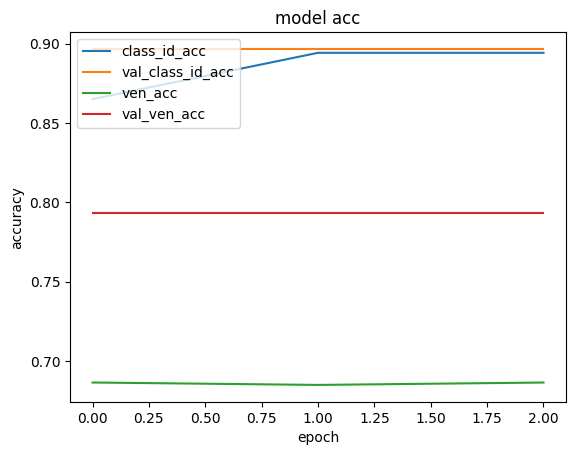

In [10]:
import matplotlib.pyplot as plt
def plot_training_graphs():
    plt.plot(history.history['class_id_accuracy'])
    plt.plot(history.history['val_class_id_accuracy'])
    plt.plot(history.history['ven_accuracy'])
    plt.plot(history.history['val_ven_accuracy'])
    plt.title('model acc')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['class_id_acc', 'val_class_id_acc', 'ven_acc', 'val_ven_acc'], loc='upper left')

plot_training_graphs()